在cifar10pythoninput中通过了python的形式读取了数据，但为了即将在Imagenet的数据集上流式读取数据，故在CIFAR10上尝试了一下，也遇到了一些问题。

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir = "bin_data/"

In [3]:
filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i)
           for i in range(1, 6)]

In [4]:
for f in filenames:
    print(f)
    if not tf.gfile.Exists(f):
      raise ValueError('Failed to find file: ' + f)

bin_data/data_batch_1.bin
bin_data/data_batch_2.bin
bin_data/data_batch_3.bin
bin_data/data_batch_4.bin
bin_data/data_batch_5.bin


In [6]:
file_reader_queue = tf.train.string_input_producer(filenames)

In [8]:
class CIFAR10Record(object):
    pass
result = CIFAR10Record()

In [9]:
label_bytes = 1
result.height = 32
result.width = 32
result.depth = 3

image_bytes = result.height * result.height * result.depth
record_bytes_lens = label_bytes + image_bytes

In [10]:
reader = tf.FixedLengthRecordReader(record_bytes=record_bytes_lens)
result.key, value = reader.read(file_reader_queue)

record_bytes = tf.decode_raw(value, tf.uint8)
result.label = tf.cast(tf.strided_slice(record_bytes, [0], [label_bytes]), tf.int32)

In [11]:
image_data = tf.strided_slice(record_bytes, [label_bytes], [record_bytes_lens])
depth_major = tf.reshape(image_data,
                         [result.depth, result.height, result.width])
result.uint8image = tf.transpose(depth_major, [1, 2, 0])
reshaped_image = tf.cast(result.uint8image, tf.float32)

In [12]:
ug = tf.reshape(tf.constant([255]*3072, dtype=tf.float32),
                [result.height, result.width, result.depth])

In [13]:
invert_image = tf.subtract(ug, reshaped_image)
result.label.set_shape([1])
num_preprocess_threads = 16

这里需要注意一点是，要是读取的数据直接显示的话，视觉上总是不对，把RGB三个通道全排列后，依然没有正确结果，必须把每个像素位反转，即$255-pixel\_value$后恢复正常
```python
ug = tf.reshape(tf.constant([255]*3072, dtype=tf.float32),
                [result.height, result.width, result.depth])
invert_image = tf.subtract(ug, reshaped_image)
```
![转换前](img/Figure_3.png)
图形在PhotoShop中颜色反向结果
![转换后](img/Figure_3_1.png)

In [15]:
images, label_batch = tf.train.shuffle_batch([invert_image, result.label],
                                             num_threads=num_preprocess_threads,
                                             batch_size=10,
                                             capacity=210,
                                             min_after_dequeue=100)
label_batch = tf.reshape(label_batch, [10])

In [16]:
init = tf.global_variables_initializer()

In [17]:
sess = tf.Session()
sess.run(init)

In [18]:
threads = tf.train.start_queue_runners(sess=sess)

In [22]:
classnames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

[1 8 0 4 0 1 8 4 4 9]


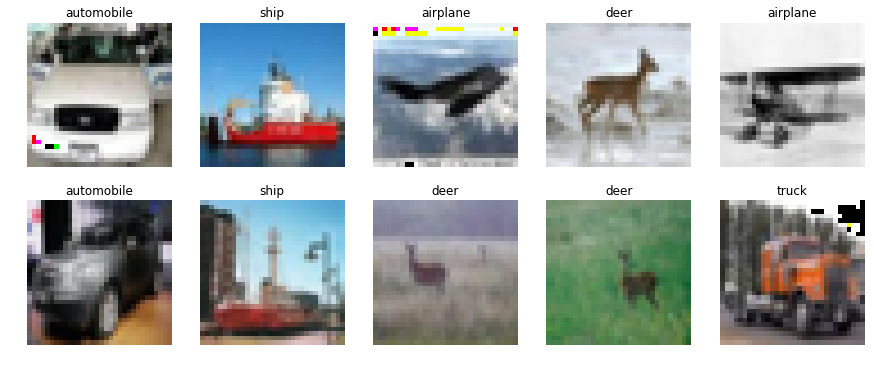

In [23]:
val, l = sess.run([images, label_batch])
fig = plt.figure(figsize=(15, 6))
print(l)
for j in range(10):
    fig.add_subplot(2, 5, j + 1)
    plt.imshow(val[j])
    plt.title(classnames[l[j]])
    plt.axis('off')